# Mini-Project 2 Part 1 & Part 2 Notebook

# Part 1: Gradient Descent Experiments with Diabetes Dataset

In [1]:
# Ignoring overflow warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Standard Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Importing Logistic Regression class
import full_batch as gd
import mini_batch as mgd

#Importing sklearn tools for text classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Importing diabetes csv data
train = pd.read_csv('../../data/diabetes/diabetes_train.csv')
test = pd.read_csv('../../data/diabetes/diabetes_test.csv')
valid = pd.read_csv('../../data/diabetes/diabetes_val.csv')
all_data = pd.concat([train, test, valid], axis=0)

## Part 1.1: optimizing the maximum iterations and learning rate parameters for the data

In [5]:
def optimize(data, max_iter, learning_rate, pred_data,e=9.5e-3, mom=0):
    """
    Optimize a logisitic regression model's weights using gradient descent.
    This function makes it easier to test different combinations of the
    maximum iterations and learning rate parameters. 
    data:           [pd.DataFrame]  Training or Training+Validation data
    max_iter:       [int]           Maximum Iterations of gradient descent
    learning_rate:  [float]
    pred_data:      [pd.DataFrame]
    returns array of class probabilities
    """
    # preformance metric
    totAcc = []
    
    # Input data, features and binary labels column
    Xin = data.drop('Outcome',axis=1).to_numpy()
    Yin = data['Outcome'].to_numpy()
    # Data to run prediction on
    Xp = pred_data.drop('Outcome',axis=1).to_numpy()
    Yp = pred_data['Outcome'].to_numpy().ravel()
    
    # Iterate through the input parameters
    for l in learning_rate:
        for m in max_iter:
            prediction = []
            temp = []
            
            print(f'\n LEARNING RATE: {l}')
            model = gd.LogisticRegression(verbose=True, add_bias=True, learning_rate=l, max_iters=m,epsilon=e,momentum=mom)
            yh = model.fit(Xin,Yin).predict(Xp)
            temp.append(yh)
        
            # Decision Boundary
            for x in np.array(temp).ravel():
                if x < 0.5: prediction.append(0)
                else: prediction.append(1)
                    
            Acc = accuracy_score(Yp,np.array(prediction).ravel())
            totAcc.append(Acc)
            print("Accuracy Score:", Acc)
    
    print(f'Maximum Test Accuracy achieved: {max(totAcc)} for the combination {learning_rate} and {max_iter}')

In [3]:
# Highest scoring result on test set and validation set
m = [1e6]
l = [2e-4]

print("RESULTS ON TEST SET: \n")
optimize(data=train, max_iter=m, learning_rate=l, pred_data=test)

print("RESULTS ON VALIDATION SET: \n")
optimize(data=train, max_iter=m, learning_rate=l, pred_data=valid)

RESULTS ON TEST SET: 


 LEARNING RATE: 0.0002
Convergence: 1000000 Iterations
Norm of gradient: 0.013429351710347736
Accuracy Score: 0.7794117647058824
Maximum Test Accuracy achieved: 0.7794117647058824 for the combination [0.0002] and [1000000.0]
RESULTS ON VALIDATION SET: 


 LEARNING RATE: 0.0002


KeyboardInterrupt: 

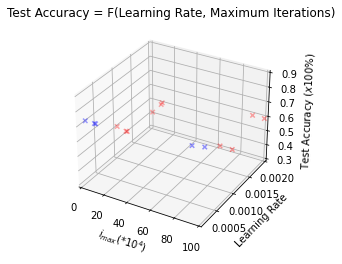

In [28]:
# Plot for test accuracy as a function of learning rates and maximum iterations

ax = plt.axes(projection='3d', title="Test Accuracy = F(Learning Rate, Maximum Iterations)")

m =   [1,1,1,
       9,9,9,
       10,10,10,
       90,90,90,
       100,100,100,
       900,900,900]

l =   [1e-3,2e-3,2e-4,
       1e-3,2e-3,2e-4,
       1e-3,2e-3,2e-4,
       1e-3,2e-3,2e-4,
       1e-3,2e-3,2e-4,
       1e-3,2e-3,2e-4]

acc = [0.5147058823529411, 0.4117647058823529, 0.7205882352941176,
       0.5, 0.4852941176470588, 0.7205882352941176,
       0.5, 0.5, 0.7205882352941176,
       0.5882352941176471, 0.5882352941176471, 0.7647058823529411,
       0.5882352941176471, 0.5882352941176471, 0.7794117647058824,
       0.6176470588235294, 0.6176470588235294, 0.75
       ]

ax.text(0,0,10,"Red points accuracy < 0.6, Blue points accuracy > 0.6",fontsize=15)


ax.set_xlabel('$i_{max}(*10^{4}$)')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Test Accuracy ($x100\%$)')

ax.set(xlim=(0, 100), ylim=(0.0001, 0.002), zlim=(0.3,0.9))

# Boundary for accuracies
color = []
for x in acc:
    if x < 0.62: color.append('r')
    else: color.append('b')

ax.scatter(m, l, acc, marker='x', c=color)

## Part 1.1 Results

* Our base model preformed better than the Sklearn SGD logisitic classifier with a margin greater than 10%

* Decision Boundary is set at X=0.5: $$P(y=1|X) < 0.5 \rightarrow \hat{y}=0$$ $$P(y=1|X) \geq 0.5 \rightarrow \hat{y}= 1$$ 


* Best accuracy achieved on the test set was 77.9%, validation set with 77% at $\alpha = 2 * 10^{-4}$ and $i_{max} = 1 * 10^6$

* Output:

```
VALIDATION SET:

LEARNING RATE: 0.0002
1000000 Iterations
Norm of gradient: 0.013429351710347736
Accuracy Score: 0.77

TEST SET:

LEARNING RATE: 0.0002
1000000 Iterations
Norm of gradient: 0.013429351710347736
Accuracy Score: 0.7794117647058824

```

## Part 1.2 Mini-Batch Stochastic Gradient Descent & Convergence Rate

### Convergence Conditions
* For the purposes of this project and from observing the past results, convergence was determined to be the conditions where accuracy was maximized and the norm of the gradient minimized (or approaching zero steadily)
* There is some tolerance we found which was $9*10^{-4} < \epsilon < 7.5*10^{-3}$
* At this particular epsilon, accuracy was maximized, but after it, overfitting started to take place even though the norm of the gradient was still approaching zero

In [2]:
def miniBatch(data, max_iter, alpha, pred_data, size, epoch=1, e=9.5e-4, mom=0):
    
    # preformance metric
    totAcc = []
    
    # Input data, features and binary labels column
    Xin = data.drop('Outcome',axis=1).to_numpy()
    Yin = data['Outcome'].to_numpy()
    # Data to run prediction on
    Xp = pred_data.drop('Outcome',axis=1).to_numpy()
    Yp = pred_data['Outcome'].to_numpy().ravel()
            
    print(f'\n LEARNING RATE: {alpha}, MAXIMUM ITERATIONS: {max_iter}')
    model = mgd.LogisticRegression(verbose=True,add_bias=True,learning_rate=alpha, max_iters=max_iter,
                                  epsilon=e, momentum=mom, batchSize=size, epochs=epoch)
    y = model.fit(Xin,Yin)

* *NOTE* Collapse the following output because it very extensive

In [ ]:
sizes = [8,16,32,64,128,150,256]

for s in sizes:
    miniBatch(data=train, max_iter=1e6, alpha=2e-4, pred_data=valid, size=s, epoch=10, e=5.5e-3)

## Part 1.2 Results

Fastest convergence per size:

   - size 8  ->  61409  Iterations
   - size 16 ->  216642 Iterations
   - size 32 ->  15419  Iterations
   - size 64 ->  8816   Iterations
   - size 128->  1971 Iterations
   - size 150->  6109 Iterations
   - size 256->  5431 Iterations
   
Highest Accuracy per size:

   - size 8  ->  0.69,0.67
   - size 16 ->  0.76,0.65
   - size 32 ->  0.72,0.64
   - size 64 ->  0.72,0.67
   - size 128->  0.70,0.67
   - size 150->  0.72,0.64
   - size 256->  0.76,0.69

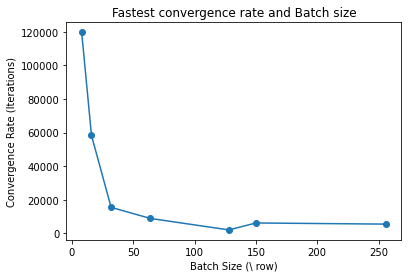

In [23]:
Tacc = [ 0.67, 0.76, 0.70, 0.72, 0.72, 0.72, 0.77]
Vacc = [0.67,  0.65, 0.64, 0.67, 0.67, 0.64, 0.69]
conv = [119827 , 58292 , 15419, 8816, 1971, 6109, 5431]
sizes = [8,16,32,64,128,150,256]

    
plt.plot(sizes,conv, marker='o')
plt.xlabel("Batch Size (\ row)")
plt.ylabel("Convergence Rate (Iterations)")
plt.title("Fastest convergence rate and Batch size")
plt.show()

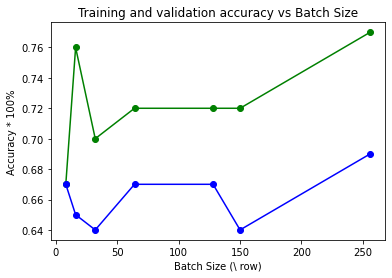

In [24]:
plt.plot(sizes,Tacc, 'g' , marker='o',label='Test Accuracy')
plt.plot(sizes, Vacc, 'b', marker='o', label='Validation Accuracy')
plt.xlabel("Batch Size (\ row)")
plt.ylabel("Accuracy * 100%")
plt.title("Training and validation accuracy vs Batch Size")
plt.show()

## Part 1.3 Gradient Descent with Momentum

In [3]:
for x in [0.2,0.8]: 
    for s in [32,256]:
        miniBatch(data=train, max_iter=1e6, alpha=2e-4, pred_data=valid, size=s, epoch=10, e=5.5e-3,mom=x)


 LEARNING RATE: 0.0002, MAXIMUM ITERATIONS: 1000000.0
Epoch: 1
Convergence: 0 Iterations
Norm of gradient: inf
Batch Size: 32    TEST accuracy: 0.6323529411764706   VALIDATION accuracy: 0.56
Epoch: 2
Convergence: 598992 Iterations
Norm of gradient: 0.005499998179746003
Batch Size: 32    TEST accuracy: 0.6323529411764706   VALIDATION accuracy: 0.65
Epoch: 3
Convergence: 438844 Iterations
Norm of gradient: 0.0054999930670331775
Batch Size: 32    TEST accuracy: 0.6911764705882353   VALIDATION accuracy: 0.56
Epoch: 4
Convergence: 308815 Iterations
Norm of gradient: 0.00549999203596777
Batch Size: 32    TEST accuracy: 0.38235294117647056   VALIDATION accuracy: 0.44
Epoch: 5
Convergence: 365945 Iterations
Norm of gradient: 0.005499984191512499
Batch Size: 32    TEST accuracy: 0.5   VALIDATION accuracy: 0.58
Epoch: 6
Convergence: 472480 Iterations
Norm of gradient: 0.005499996723543731
Batch Size: 32    TEST accuracy: 0.5588235294117647   VALIDATION accuracy: 0.54
Epoch: 7
Convergence: 17641

KeyboardInterrupt: 

In [7]:
for x in [0.2,0.6,0.8]:
    optimize(data=train, max_iter=[1e6], learning_rate=[2e-4], pred_data=test,mom=x, e=1.5e-3)


 LEARNING RATE: 0.0002
Convergence: 848412 Iterations
Norm of gradient: 0.0014999994796325523
Accuracy Score: 0.7058823529411765
Maximum Test Accuracy achieved: 0.7058823529411765 for the combination [0.0002] and [1000000.0]

 LEARNING RATE: 0.0002
Convergence: 848413 Iterations
Norm of gradient: 0.0014999982811076313
Accuracy Score: 0.7058823529411765
Maximum Test Accuracy achieved: 0.7058823529411765 for the combination [0.0002] and [1000000.0]

 LEARNING RATE: 0.0002
Convergence: 848414 Iterations
Norm of gradient: 0.0014999994161790106
Accuracy Score: 0.7058823529411765
Maximum Test Accuracy achieved: 0.7058823529411765 for the combination [0.0002] and [1000000.0]


## Part 1.4 Momentum in small mini-batch and large mini-batch gradient descent

# Part 2: Text Classification with Fake News Dataset

In [ ]:
fake_news_training = pd.read_csv('../data/fake_news/fake_news_train.csv')
fake_news_validation = pd.read_csv('../data/fake_news/fake_news_val.csv')
fake_news_test = pd.read_csv('../data/fake_news/fake_news_test.csv')


### Base case

In [ ]:
vectorizer = CountVectorizer()

vectorizer.fit(fake_news_training['text'])
training_features = vectorizer.transform(fake_news_training['text'])
validation_features = vectorizer.transform(fake_news_validation['text'])

# Model Training
clf = LogisticRegression(max_iter=1000, C=4.25e-02)
clf.fit(training_features, fake_news_training['label'])

# Model Prediction
y_pred = clf.predict(validation_features)
y_true = fake_news_validation['label']

accuracy = metrics.accuracy_score(y_true, y_pred)

print(f'base accuracy of model on validation set: {accuracy}')

### Preprocessing

In NLP questions, preprocessing decision for data are extremely important.
For the following problem the different preprocessing decisions that were explored were:

* n-grams
* stopword removal
* token selection

The CountVectorizer below has been set with the values that we determined for the model through training.

### Hyper parameter training

Once a solid set of preprocessign results with a good general model were
constructed, the model had to be trained on certain hyperpramateres.

* the value of C
* minimum document frequency
* maximum document frequency
* maximum number of features

On further training it was noted that min_df value did not really matter as only the top 300,000 features were
being used.

In [ ]:
# The final model

# Feature Extraction
vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r"\b[^\d\W]+\b|\b[0-9]+\b", min_df=3, max_features=300000)
vectorizer.fit(fake_news_training['text'])
training_features = vectorizer.transform(fake_news_training['text'])
validation_features = vectorizer.transform(fake_news_validation['text'])

# Model Training
clf = LogisticRegression(max_iter=1000, C=4.25e-02)
clf.fit(training_features, fake_news_training['label'])

# Model Prediction
y_pred = clf.predict(validation_features)
y_true = fake_news_validation['label']

accuracy = metrics.accuracy_score(y_true, y_pred)
confusion = metrics.confusion_matrix(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)

print(f'Best model has accuracy: {accuracy}%, precision: {precision}%, and reacll: {recall}')
print("Confusion Matrix:")
print(confusion)

## HyperParam testing data

The data recieved on testing the data with different hyperparameters for using LogisticRegressionCV

Note: The data below was collected through multiple tests and iterations of the code, and compiled for visualization below. 

### C values

In [ ]:
Cs = [0.000774263683, 0.0059948425, 0.01, 0.01, 0.035, 0.0375, 0.04, 0.04, 0.0425, 0.045, 0.0464158883, 0.07, 0.09, 0.359381366, 0.5, 0.75, 1, 1.25, 1.5, 2, 2.7825594]
mean_acc_c = [0.7344, 0.76475, 0.7613, 0.76535, 0.7688, 0.76915, 0.7655, 0.766, 0.76945, 0.7695, 0.76965, 0.76825, 0.76515, 0.76495, 0.76075, 0.76935, 0.76805, 0.7682, 0.7694, 0.7657, 0.7651]
max_acc_c = [0.74275, 0.77175, 0.77675, 0.7775, 0.779, 0.77975, 0.778, 0.779, 0.7805, 0.7805, 0.7805, 0.7755, 0.78, 0.78075, 0.77625, 0.781, 0.78025, 0.7815, 0.781, 0.77775, 0.78175]
df = pd.DataFrame(list(zip(Cs, mean_acc_c, max_acc_c)), columns=["C values", "Mean accuracy", "Max accuracy"])

plt.plot('C values', 'Mean accuracy', data=df, marker='', color="olive")
plt.plot('C values', 'Max accuracy', data=df, marker='', color="pink")

plt.legend()
plt.grid()

plt.show()
plt.savefig("C-vals_complete.png")

### C values on final iteration

C value was finally picked as 0.0425

In [ ]:
Cs = [ 0.035, 0.0375, 0.04, 0.04, 0.0425, 0.045, 0.0464158883]
mean_acc_c = [ 0.7688, 0.76915, 0.7655, 0.766, 0.76945, 0.7695, 0.76965]
max_acc_c = [ 0.779, 0.77975, 0.778, 0.779, 0.7805, 0.7805, 0.7805]
df = pd.DataFrame(list(zip(Cs, mean_acc_c, max_acc_c)), columns=["C values", "Mean accuracy", "Max accuracy"])

plt.plot('C values', 'Mean accuracy', data=df, marker='', color="olive")
plt.plot('C values', 'Max accuracy', data=df, marker='', color="pink")

plt.legend()
plt.grid()

for i,j in zip(Cs,mean_acc_c):
    plt.annotate(str(j),xy=(i,j))

for i,j in zip(Cs,max_acc_c):
    plt.annotate(str(j),xy=(i,j))

plt.show()
plt.savefig("C-vals_final.png")

### max_feature hyperparameter tuning

Through this data we picked 300000 as our max number of features

In [ ]:
max = [50000, 100000, 150000, 200000, 250000, 300000, 350000]
mean_acc_c = [0.758, 0.76445, 0.76545, 0.76725, 0.76755, 0.7678, 0.7683]
max_acc_c = [0.76875, 0.77575, 0.77825, 0.7785, 0.7805, 0.77925, 0.779]
validation = [0.7825, 0.7855, 0.76875, 0.77825, 0.7855, 0.7865, 0.7865]

df = pd.DataFrame(list(zip(max, mean_acc_c, max_acc_c, validation)), columns=["C values", "Mean accuracy", "Max accuracy", "Acc. on validation"])

plt.plot('C values', 'Mean accuracy', data=df, marker='', color="olive")
plt.plot('C values', 'Max accuracy', data=df, marker='', color="pink")
plt.plot('C values', 'Acc. on validation', data=df, marker='', color="cyan")

plt.legend()
plt.grid()

for i,j in zip(max,mean_acc_c):
    plt.annotate(str(j),xy=(i,j))

for i,j in zip(max,max_acc_c):
    plt.annotate(str(j),xy=(i,j))

for i,j in zip(max,validation):
    plt.annotate(str(j),xy=(i,j))

plt.show()
plt.savefig("max-feature-vals-complete.png")
